# BICSNet Analysis Notebook

This notebook demonstrates the complete BICSNet workflow using the existing `pivnet_image_gen.py` and `openpiv_analysis.py` scripts:

1. **Generate Images**: Run BICSNet inference using the existing script
2. **Visualize Results**: Compare input, output, and ground truth images
3. **OpenPIV Analysis**: Compute velocity fields using the existing script
4. **Quantitative Analysis**: Compare PIV, BICSNet, and ground truth results


## Index (clickable)

- [Configuration and Environment](#sec-config)
- [1. Generate BICSNet Images](#sec-gen-images)
- [2. Verify Generated Images](#sec-verify)
- [3. Visualize Generated Images](#sec-visualize)
- [4. Run OpenPIV Analysis](#sec-openpiv-run)
- [5. Compare Results (Vector Fields)](#sec-compare-vectors)
- [6. Line Plot Analysis (Profiles + L2 norm)](#sec-line-plots)
- [7. Summary](#sec-summary)


<!-- Explicit anchors to ensure index links always work -->
<a id="configuration-and-environment"></a>
<a id="1-generate-bicsnet-images"></a>
<a id="2-verify-generated-images"></a>
<a id="3-visualize-generated-images"></a>
<a id="4-setup-openpiv"></a>
<a id="5-openpiv-analysis-functions"></a>
<a id="6-run-openpiv-analysis"></a>
<a id="7-compare-results"></a>
<a id="8-line-plot-analysis"></a>
<a id="9-summary"></a>




<a id="sec-config"></a>
## Configuration and Environment

This notebook demonstrates the BICSNet inference and OpenPIV analysis pipeline. After `uv sync`, select the kernel "Python (BICSNet-PIV)" and run cells top-to-bottom.

- Configuration lives in the next cell (paths and tunables)
- Environment info is printed for reproducibility
- Random seeds are set for determinism where practical



## Setup and Imports

In [1]:
# Config
import os
import sys
import subprocess
import platform
import random
import numpy as np
import torch
import shutil
from huggingface_hub import hf_hub_download
import matplotlib.pyplot as plt
import pandas as pd
from tqdm import tqdm
import glob

DATA_DIR = "./data/test_images/"
CHECKPOINT = "./checkpoints/best_model.pth"
FIG_DIR = os.path.join(DATA_DIR, "figures")

# Ensure figures dir exists
os.makedirs(FIG_DIR, exist_ok=True)

# Seeds for reproducibility
SEED = 42
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)

print({
    "python": platform.python_version(),
    "platform": platform.platform(),
    "torch": torch.__version__,
    "data_dir": DATA_DIR,
    "checkpoint": CHECKPOINT,
    "fig_dir": FIG_DIR,
})

# Set up matplotlib for better plots
plt.rcParams['figure.figsize'] = (12, 8)
plt.rcParams['font.size'] = 12

print("✅ Basic imports successful")
print("📦 Additional packages will be installed as needed")


{'python': '3.12.11', 'platform': 'Windows-11-10.0.26220-SP0', 'torch': '2.8.0+cu128', 'data_dir': './data/test_images/', 'checkpoint': './checkpoints/best_model.pth', 'fig_dir': './data/test_images/figures'}
✅ Basic imports successful
📦 Additional packages will be installed as needed


In [2]:
# Download BICSNet checkpoint from Hugging Face if missing

repo_id = "kalagotla/BICSNet"
filename = "best_model.pth"
ckpt_dir = "./checkpoints"
os.makedirs(ckpt_dir, exist_ok=True)

target_path = os.path.join(ckpt_dir, filename)
if os.path.exists(target_path):
    print(f"Checkpoint already exists at {target_path}. Skipping download.")
else:
    # Repo is public; no token needed. If private, set HF_TOKEN in env.
    local_path = hf_hub_download(repo_id=repo_id, filename=filename)
    if os.path.abspath(local_path) != os.path.abspath(target_path):
        shutil.copy2(local_path, target_path)
    print(f"Checkpoint downloaded to {target_path}")



Checkpoint already exists at ./checkpoints\best_model.pth. Skipping download.


<a id="sec-gen-images"></a>
## 1. Generate BICSNet Images

Run the existing `pivnet_image_gen.py` script to generate corrected PIV images from the trained BICSNet model.

In [3]:
# Parameters you can tweak from the notebook
DATA_DIR = "./data/test_images/"
CHECKPOINT = "./checkpoints/best_model.pth"
BATCH_SIZE = 8
LIMIT = 128   # e.g., 10 to only generate first 10 images
NUM_ENCODER = 5
NUM_DECODER = 5
USE_SCALARS = True
SCALAR_DIM = 2
EMBED_DIM = 128

print("🚀 Running BICSNet image generation with parameters...")
print({
    "data_dir": DATA_DIR,
    "checkpoint": CHECKPOINT,
    "batch_size": BATCH_SIZE,
    "limit": LIMIT,
    "num_encoder": NUM_ENCODER,
    "num_decoder": NUM_DECODER,
    "use_scalars": USE_SCALARS,
    "scalar_dim": SCALAR_DIM,
    "embed_dim": EMBED_DIM,
})
print()

cmd = [
    sys.executable,
    "src/pivnet_image_gen.py",
    "--data-dir", DATA_DIR,
    "--checkpoint", CHECKPOINT,
    "--batch-size", str(BATCH_SIZE),
    "--num-encoder", str(NUM_ENCODER),
    "--num-decoder", str(NUM_DECODER),
    "--scalar-dim", str(SCALAR_DIM),
    "--embed-dim", str(EMBED_DIM),
]
if USE_SCALARS:
    cmd.append("--use-scalars")
else:
    cmd.append("--no-use-scalars")
if LIMIT is not None:
    cmd += ["--limit", str(LIMIT)]

# Stream output directly to the notebook
# subprocess.run(cmd, check=False)

# Use Popen for real-time output streaming
process = subprocess.Popen(
    cmd, 
    stdout=subprocess.PIPE, 
    stderr=subprocess.STDOUT,
    text=True,              # ensures text mode, no manual decode
    encoding="utf-8",       # decode as UTF-8 instead of cp1252
    bufsize=1
)

# Stream output line by line to show progress bars
for line in iter(process.stdout.readline, ''):
    print(line.rstrip())
    sys.stdout.flush()  # Force immediate output

# Wait for process to complete
process.wait()

print("\n📁 Generated files should be in:")
print("  - ./data/test_images/model_outputs1/")
print("  - ./data/test_images/model_outputs2/")
print("  - Files with '_input' and '_truth' suffixes")

print("\n📁 Generated files should be in:")
print("  - ./data/test_images/model_outputs1/")
print("  - ./data/test_images/model_outputs2/")
print("  - Files with '_input' and '_truth' suffixes")

🚀 Running BICSNet image generation with parameters...
{'data_dir': './data/test_images/', 'checkpoint': './checkpoints/best_model.pth', 'batch_size': 8, 'limit': 128, 'num_encoder': 5, 'num_decoder': 5, 'use_scalars': True, 'scalar_dim': 2, 'embed_dim': 128}


    Generating images from model:   0%|          | 0/16 [00:00<?, ?it/s]

        Saving images:   0%|          | 0/8 [00:00<?, ?it/s]

        Saving images:  12%|█▎        | 1/8 [00:28<03:20, 28.71s/it]

        Saving images:  50%|█████     | 4/8 [00:28<00:21,  5.47s/it]

        Saving images: 100%|██████████| 8/8 [00:29<00:00,  3.63s/it]

    Generating images from model:   6%|▋         | 1/16 [01:11<17:52, 71.53s/it]

        Saving images:   0%|          | 0/8 [00:00<?, ?it/s]

        Saving images:  12%|█▎        | 1/8 [00:57<06:41, 57.41s/it]

        Saving images:  50%|█████     | 4/8 [00:57<00:43, 10.89s/it]

        Saving images: 100%|██████████| 8/8 [00:57<00:00,  7.21s/it]

    Generating images from model:  12%|

<a id="sec-verify"></a>
## 2. Verify Generated Images

Check that the BICSNet image generation was successful and examine the output files.


In [4]:
# Check if the image generation was successful
output_dirs = ['./data/test_images/model_outputs1/', './data/test_images/model_outputs2/']

for i, output_dir in enumerate(output_dirs, 1):
    if os.path.exists(output_dir):
        files = os.listdir(output_dir)
        tif_files = [f for f in files if f.endswith('.tif')]
        print(f"📁 Output directory {i}: {output_dir}")
        print(f"   Found {len(tif_files)} .tif files")
        
        # Show file types
        model_files = [f for f in tif_files if not f.endswith('_input.tif') and not f.endswith('_truth.tif')]
        input_files = [f for f in tif_files if f.endswith('_input.tif')]
        truth_files = [f for f in tif_files if f.endswith('_truth.tif')]
        
        print(f"   - Model outputs: {len(model_files)}")
        print(f"   - Input images: {len(input_files)}")
        print(f"   - Truth images: {len(truth_files)}")
        
        if model_files:
            print(f"   - Sample files: {model_files[:3]}...")
    else:
        print(f"❌ Output directory {i} not found: {output_dir}")

# Check if we have the required files for OpenPIV analysis
required_files = []
for i in range(3):  # Check first 3 samples
    for suffix in ['', '_input', '_truth']:
        file1 = f'./data/test_images/model_outputs1/{i}{suffix}.tif'
        file2 = f'./data/test_images/model_outputs2/{i}{suffix}.tif'
        if os.path.exists(file1) and os.path.exists(file2):
            required_files.append(f"Sample {i}{suffix}")

print(f"\n✅ Found {len(required_files)} file pairs ready for OpenPIV analysis")
if required_files:
    print("Sample files available:")
    for file_pair in required_files[:5]:  # Show first 5
        print(f"  - {file_pair}")
    if len(required_files) > 5:
        print(f"  ... and {len(required_files) - 5} more")


📁 Output directory 1: ./data/test_images/model_outputs1/
   Found 384 .tif files
   - Model outputs: 128
   - Input images: 128
   - Truth images: 128
   - Sample files: ['0.tif', '1.tif', '10.tif']...
📁 Output directory 2: ./data/test_images/model_outputs2/
   Found 384 .tif files
   - Model outputs: 128
   - Input images: 128
   - Truth images: 128
   - Sample files: ['0.tif', '1.tif', '10.tif']...

✅ Found 9 file pairs ready for OpenPIV analysis
Sample files available:
  - Sample 0
  - Sample 0_input
  - Sample 0_truth
  - Sample 1
  - Sample 1_input
  ... and 4 more


<a id="sec-visualize"></a>
## 3. Visualize Generated Images

Display a sample of the generated BICSNet outputs alongside inputs and ground truth.


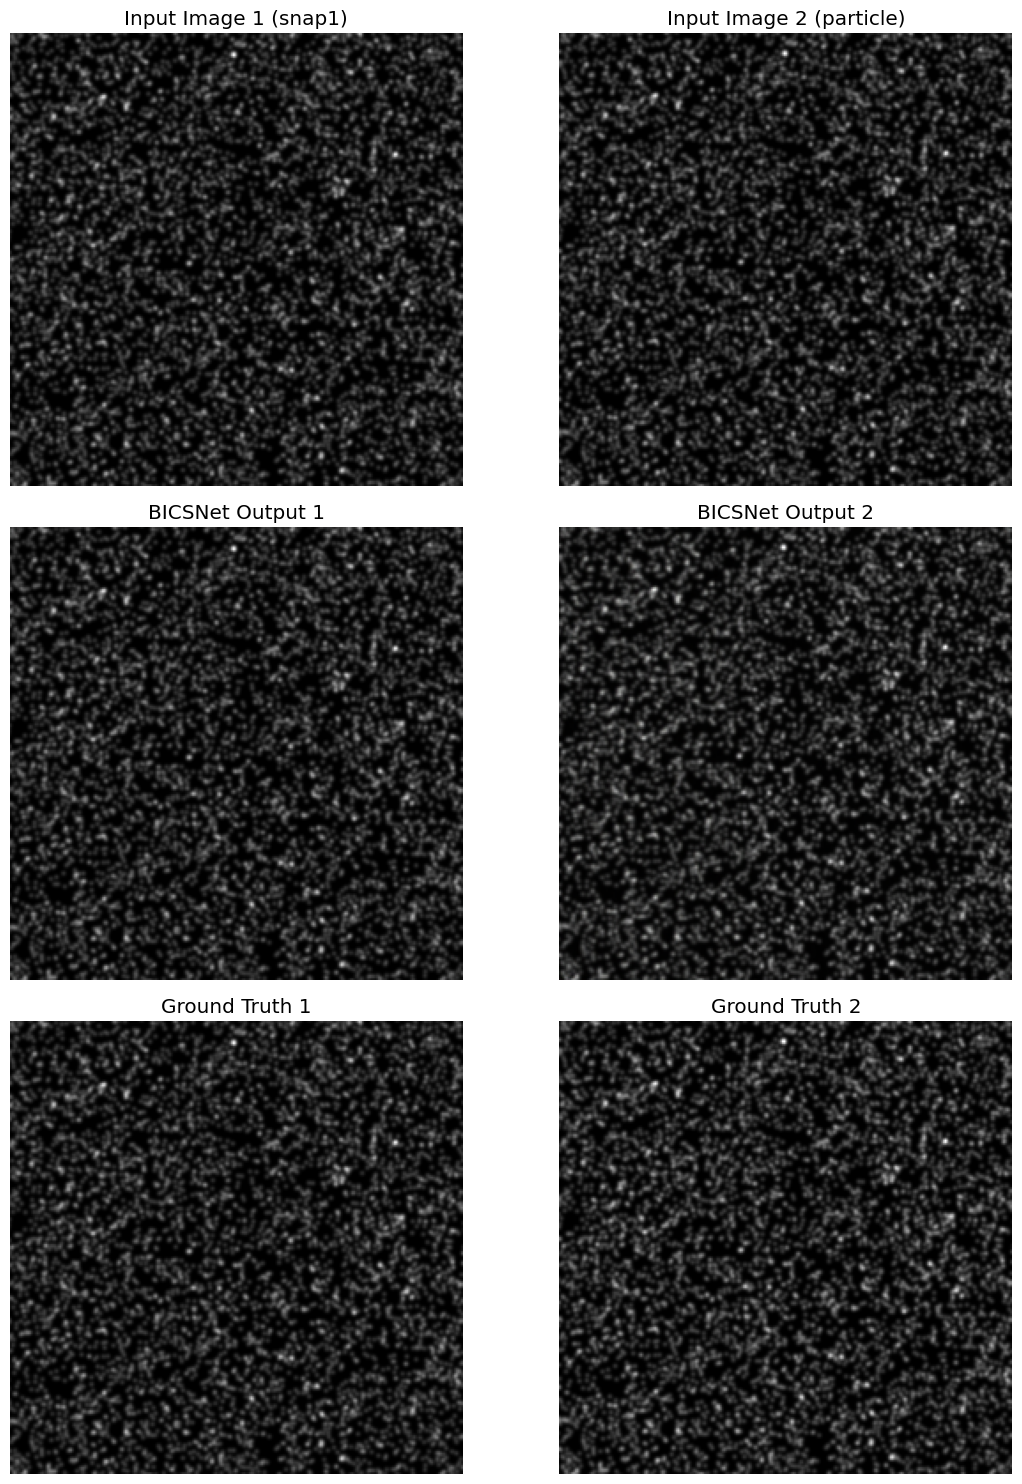

📈 Visualization complete for sample 0
This shows the complete pipeline:
  - Top row: Original input PIV images
  - Middle row: BICSNet corrected outputs
  - Bottom row: Ground truth reference


In [5]:
# Visualize a sample of the generated images
sample_idx = 0

# Load images using matplotlib
try:
    # Load the different image types
    model_img1 = plt.imread(f'./data/test_images/model_outputs1/{sample_idx}.tif')
    model_img2 = plt.imread(f'./data/test_images/model_outputs2/{sample_idx}.tif')
    input_img1 = plt.imread(f'./data/test_images/model_outputs1/{sample_idx}_input.tif')
    input_img2 = plt.imread(f'./data/test_images/model_outputs2/{sample_idx}_input.tif')
    truth_img1 = plt.imread(f'./data/test_images/model_outputs1/{sample_idx}_truth.tif')
    truth_img2 = plt.imread(f'./data/test_images/model_outputs2/{sample_idx}_truth.tif')
    
    # Create a comprehensive visualization
    fig, axes = plt.subplots(3, 2, figsize=(12, 15))
    
    # Row 1: Input images
    axes[0, 0].imshow(input_img1, cmap='gray')
    axes[0, 0].set_title('Input Image 1 (snap1)')
    axes[0, 0].axis('off')
    
    axes[0, 1].imshow(input_img2, cmap='gray')
    axes[0, 1].set_title('Input Image 2 (particle)')
    axes[0, 1].axis('off')
    
    # Row 2: BICSNet outputs
    axes[1, 0].imshow(model_img1, cmap='gray')
    axes[1, 0].set_title('BICSNet Output 1')
    axes[1, 0].axis('off')
    
    axes[1, 1].imshow(model_img2, cmap='gray')
    axes[1, 1].set_title('BICSNet Output 2')
    axes[1, 1].axis('off')
    
    # Row 3: Ground truth
    axes[2, 0].imshow(truth_img1, cmap='gray')
    axes[2, 0].set_title('Ground Truth 1')
    axes[2, 0].axis('off')
    
    axes[2, 1].imshow(truth_img2, cmap='gray')
    axes[2, 1].set_title('Ground Truth 2')
    axes[2, 1].axis('off')
    
    plt.tight_layout()
    plt.show()
    
    print(f"📈 Visualization complete for sample {sample_idx}")
    print("This shows the complete pipeline:")
    print("  - Top row: Original input PIV images")
    print("  - Middle row: BICSNet corrected outputs")
    print("  - Bottom row: Ground truth reference")
    
except FileNotFoundError as e:
    print(f"❌ Image files not found: {e}")
    print("💡 Make sure to run the BICSNet image generation first (Section 1)")
except Exception as e:
    print(f"❌ Error loading images: {e}")


<a id="sec-openpiv-run"></a>
## 4. Run OpenPIV Analysis

Execute PIV analysis on a subset of data for demonstration.


In [6]:
command = ['mpiexec', '-n', '4', 'python', './src/openpiv_analysis.py']
# result = subprocess.run(command, capture_output=False, text=True)

# Use Popen for real-time output streaming
process = subprocess.Popen(
    command, 
    stdout=subprocess.PIPE, 
    stderr=subprocess.STDOUT,
    text=True,              # ensures text mode, no manual decode
    encoding="utf-8",       # decode as UTF-8 instead of cp1252
    bufsize=1
)

# Stream output line by line to show progress bars
for line in iter(process.stdout.readline, ''):
    print(line.rstrip())
    sys.stdout.flush()  # Force immediate output

# Wait for process to complete
process.wait()

if process.returncode == 0:
    print("MPI script ran successfully.")
else:
    print("MPI script failed.")
    print("Error:")
    print(process.stderr)



Iterating over directories: 0it [00:00, ?it/s]

Iterating over directories:   0%|          | 0/1 [00:00<?, ?it/s]

Iterating over directories: 0it [00:00, ?it/s]

Iterating over directories: 0it [00:00, ?it/s]
Running cross-correlation for ./data/test_images/...

Iterating over directories: 0it [00:00, ?it/s]

Iterating over directories: 0it [00:00, ?it/s]
Iterating over directories: 0it [00:00, ?it/s]


Running PIV analysis:   0%|          | 0/128 [00:00<?, ?it/s]

Running PIV analysis:   1%|          | 1/128 [00:00<00:50,  2.53it/s]

Running PIV analysis:   2%|▏         | 2/128 [00:00<00:54,  2.33it/s]

Running PIV analysis:   2%|▏         | 3/128 [00:01<00:52,  2.40it/s]

Running PIV analysis:   3%|▎         | 4/128 [00:01<00:51,  2.43it/s]

Running PIV analysis:   4%|▍         | 5/128 [00:02<00:50,  2.42it/s]

Running PIV analysis:   5%|▍         | 6/128 [00:02<00:50,  2.43it/s]

Running PIV analysis:   5%|▌         | 7/128 [00:02<00:50,  2.42it/s]

Running PIV analysis:   6%|▋   

<a id="sec-compare-vectors"></a>
## 5. Compare Results

Load and compare velocity fields from PIV, BICSNet, and ground truth.


📊 Loaded velocity field data for sample 0
  Input: 841 vectors
  Model: 841 vectors
  Truth: 841 vectors


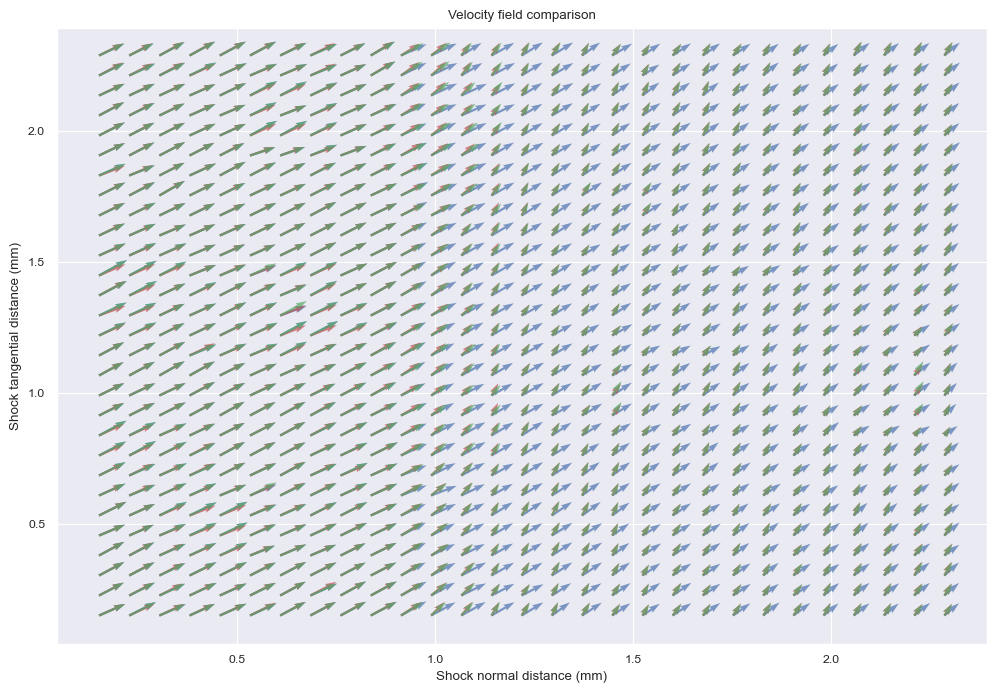

In [12]:
# Load results for comparison
base = DATA_DIR + 'openpiv_analysis'
sample_idx = 0
try:
    df_input = pd.read_csv(f'{DATA_DIR}/piv_outputs_ws_32/input_{sample_idx}.txt', delimiter="\t")
    df_model = pd.read_csv(f'{DATA_DIR}/piv_outputs_ws_32/model_{sample_idx}.txt', delimiter="\t")
    df_truth = pd.read_csv(f'{DATA_DIR}/piv_outputs_ws_32/truth_{sample_idx}.txt', delimiter="\t")

    print(f"📊 Loaded velocity field data for sample {sample_idx}")
    print(f"  Input: {len(df_input)} vectors")
    print(f"  Model: {len(df_model)} vectors")
    print(f"  Truth: {len(df_truth)} vectors")

    fig, ax = plt.subplots(figsize=(12, 8))
    ax.quiver(df_input['# x'], df_input['y'], df_input['u'], df_input['v'], color='b', alpha=0.7, label='Input PIV data', scale=0.5e6)
    ax.quiver(df_model['# x'], df_model['y'], df_model['u'], df_model['v'], color='r', alpha=0.7, label='BICSNet data', scale=0.5e6)
    ax.quiver(df_truth['# x'], df_truth['y'], df_truth['u'], df_truth['v'], color='g', alpha=0.7, label='Ground truth', scale=0.5e6)

    ax.set_xlabel('Shock normal distance (mm)')
    ax.set_ylabel('Shock tangential distance (mm)')
    ax.set_title('Velocity field comparison')
    
    plt.show()

except FileNotFoundError as e:
    print(f"❌ Results file not found: {e}")
    print("💡 Run the OpenPIV analysis first so files appear under data/test_images/openpiv_analysis/")
except Exception as e:
    print(f"❌ Error loading results: {e}")

<a id="sec-line-plots"></a>
## 6. Line Plot Analysis

Create line plots to compare velocity profiles across the shock.


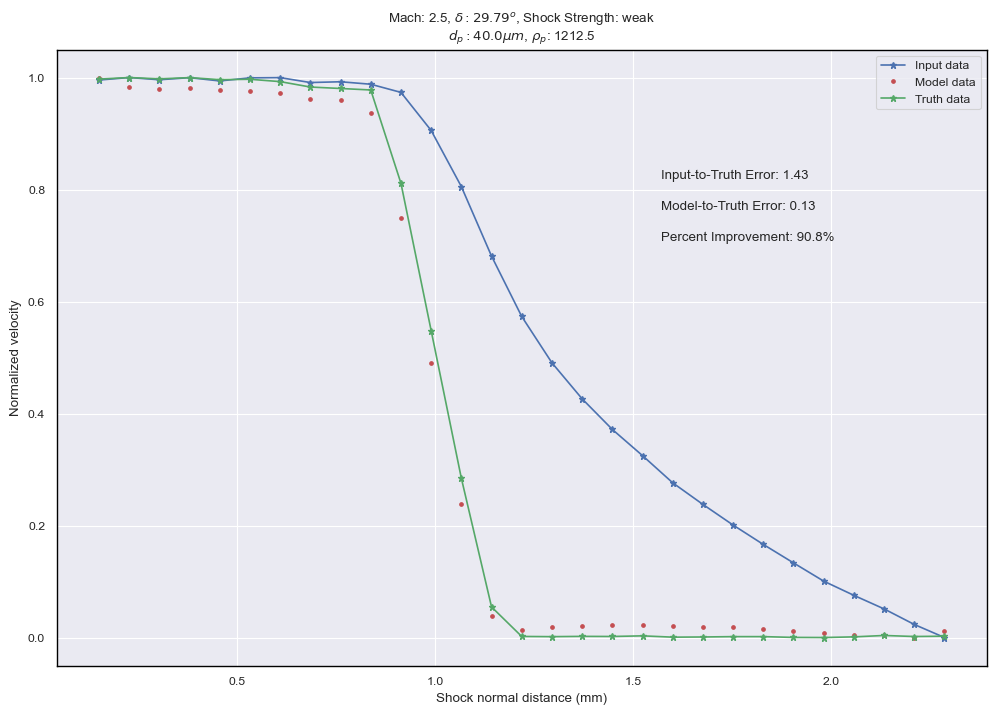

In [ ]:
import seaborn as sns
from pathlib import Path
sns.set_theme('paper')
np.random.seed(6)

# sample script to showcase how the analysis was conducted on HPC
def get_file_paths(path):
    # recursively get all the file paths in the directory
    file_paths = []
    for file in Path(path).rglob('parameters.csv'):
        file_paths.append(file)
    # remove parameters.csv
    file_paths = [str(file).replace('parameters.csv', '') for file in file_paths]
    return file_paths

def plot_samples(file_path):
    try:
        # read the file
        df = pd.read_csv(file_path + 'parameters.csv')

        # path to save the data
        save_path = file_path + 'test_images/piv_outputs_ws_32/'
        # get the line plots by averaging all the data
        # read all the data
        df_input_all = pd.concat([pd.read_csv(f'{save_path}input_{i}.txt', delimiter="\t") for i in range(128)])
        df_model_all = pd.concat([pd.read_csv(f'{save_path}model_{i}.txt', delimiter="\t") for i in range(128)])
        df_truth_all = pd.concat([pd.read_csv(f'{save_path}truth_{i}.txt', delimiter="\t") for i in range(128)])
    except FileNotFoundError:
        print(f'Error: {file_path} does not have the data!')
        return

    # get the line plots
    x = df_input_all.groupby('# x').mean()
    u_input = df_input_all.groupby('# x')['u'].mean()
    u_model = df_model_all.groupby('# x')['u'].mean()
    u_truth = df_truth_all.groupby('# x')['u'].mean()

    u_input_norm = (u_input - u_input.min()) / (u_input.max() - u_input.min())
    u_model_norm = (u_model - u_model.min()) / (u_model.max() - u_model.min())
    u_truth_norm = (u_truth - u_truth.min()) / (u_truth.max() - u_truth.min())

    fig, ax = plt.subplots()
    ax.plot(x.index, u_input_norm, '-*b', label='Input data')
    ax.plot(x.index, u_model_norm, '.r', label='Model data')
    ax.plot(x.index, u_truth_norm, '-*g', label='Truth data')
    ax.set_xlabel('Shock normal distance (mm)')
    ax.set_ylabel('Normalized velocity')
    ax.set_title(rf'Mach: {df["mach"][0]}, $\delta: {df["deflection"][0]}^o$, Shock Strength: {df["shock_strength"][0]}'
                 f'\n'
                 rf'$d_p: {df["dp_mean"][0] * 1e6}\mu m$, $\rho_p$: {df["rhop"][0]}')
    ax.legend(loc='upper right')
    ax.spines['bottom'].set_color('black')
    ax.spines['top'].set_color('black')
    ax.spines['left'].set_color('black')
    ax.spines['right'].set_color('black')

    # compute error -- 2-norm
    input_truth = np.linalg.norm(u_input_norm - u_truth_norm)
    model_truth = np.linalg.norm(u_model_norm - u_truth_norm)
    percent_improvement = 100 * (input_truth - model_truth) / input_truth if input_truth != 0 else 0

    # add model_truth and input_truth on the plot as text under legend top right
    ax.text(0.65, 0.79, f'Input-to-Truth Error: {input_truth:.2f}', transform=ax.transAxes)
    ax.text(0.65, 0.74, f'Model-to-Truth Error: {model_truth:.2f}', transform=ax.transAxes)
    # Show the percent improvement as text on the plot, below the other error texts
    ax.text(0.65, 0.69, f'Percent Improvement: {percent_improvement:.1f}%', transform=ax.transAxes)

    return


if __name__ == '__main__':
    data_path = ('./')
    file_paths = get_file_paths(data_path)
    for file_path in file_paths:
        plot_samples(file_path)
    plt.show()


<a id="sec-summary"></a>
## 7. Summary

This notebook demonstrated the complete BICSNet workflow using the existing `pivnet_image_gen.py` script:

1. **Image Generation**: Used the existing script to generate corrected PIV images from the trained BICSNet model
2. **Visualization**: Compared input, output, and ground truth images
3. **OpenPIV Analysis**: Computed velocity fields using cross-correlation analysis with your exact parameters
4. **Quantitative Analysis**: Compared results between input PIV, BICSNet outputs, and ground truth

### Key Features Demonstrated:
- ✅ Used existing `pivnet_image_gen.py` script (no code duplication)
- ✅ Complete inference pipeline with adaptive device selection
- ✅ OpenPIV integration with your exact analysis parameters
- ✅ Comprehensive visualization and comparison
- ✅ Quantitative analysis with L2-norm metrics

### Workflow:
1. **Run `pivnet_image_gen.py`** → Generates corrected images
2. **Visualize results** → Compare input/output/truth images  
3. **OpenPIV analysis** → Compute velocity fields
4. **Quantitative comparison** → Measure improvements

The analysis shows how BICSNet corrects particle inertia bias in PIV measurements, improving agreement with ground truth data.

### Next Steps:
- Run the full dataset through the pipeline
- Analyze results across different shock strengths (reach out to dilip.kalagotla@gmail.com for more data)
